# E-Commerce Furniture Sales Analysis

**Dataset:** 2,000 furniture products scraped from AliExpress  
**Goal:** Figure out what drives sales and build a model to predict them

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# create folders for outputs
os.makedirs('visualizations', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print('setup done')

setup done


In [2]:
# load data
df = pd.read_csv('/content/ecommerce_furniture_dataset_2024.csv')
print(f'loaded {len(df):,} products')
df.head()

loaded 2,000 products


,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


## 2. Data Cleaning

Raw data needs some work - prices have dollar signs, lots of missing originalPrice values.

In [3]:
# check whats missing
print('missing values:')
print(df.isnull().sum())
print(f'\nmissing originalPrice: {df["originalPrice"].isna().sum()} ({df["originalPrice"].isna().mean()*100:.1f}%)')

missing values:
productTitle        0
originalPrice    1513
price               0
sold                0
tagText             3
dtype: int64

missing originalPrice: 1513 (75.6%)


In [4]:
# clean price columns - strip $ and commas
def clean_price(x):
    if pd.isna(x) or x == '':
        return np.nan
    return float(str(x).replace('$', '').replace(',', ''))

df['price_clean'] = df['price'].apply(clean_price)
df['original_price_clean'] = df['originalPrice'].apply(clean_price)

print(f'price range: ${df["price_clean"].min():.2f} - ${df["price_clean"].max():.2f}')
print(f'avg price: ${df["price_clean"].mean():.2f}')
print(f'median: ${df["price_clean"].median():.2f}')

price range: $0.99 - $2876.38
avg price: $156.56
median: $114.08


In [5]:
# discount features
df['has_discount'] = df['original_price_clean'].notna()
df['discount_pct'] = np.where(
    df['has_discount'],
    (df['original_price_clean'] - df['price_clean']) / df['original_price_clean'] * 100,
    0
)

print(f'products with discount: {df["has_discount"].sum()} ({df["has_discount"].mean()*100:.1f}%)')
print(f'avg discount when present: {df.loc[df["has_discount"], "discount_pct"].mean():.1f}%')

products with discount: 487 (24.3%)
avg discount when present: 47.2%


In [6]:
# shipping
df['free_shipping'] = df['tagText'].str.contains('Free shipping', na=False).astype(int)
print(f'free shipping: {df["free_shipping"].sum()} products ({df["free_shipping"].mean()*100:.1f}%)')

free shipping: 1880 products (94.0%)


In [7]:
# extract category from title
categories = ['chair', 'table', 'sofa', 'bed', 'dresser', 'desk', 'cabinet', 'wardrobe', 'shelf', 'stool']

def get_category(title):
    title_lower = str(title).lower()
    for cat in categories:
        if cat in title_lower:
            return cat.title()
    return 'Other'

df['category'] = df['productTitle'].apply(get_category)
print('category counts:')
print(df['category'].value_counts())

category counts:
category
Table       703
Chair       462
Bed         277
Sofa        167
Cabinet     135
Other       100
Desk         48
Dresser      47
Stool        29
Wardrobe     20
Shelf        12
Name: count, dtype: int64


In [8]:
# title features
df['title_length'] = df['productTitle'].str.len()
df['title_word_count'] = df['productTitle'].str.split().str.len()

# price tiers
def price_tier(price):
    if price < 50:
        return 'Budget (<$50)'
    elif price < 150:
        return 'Mid-Range ($50-150)'
    elif price < 300:
        return 'Premium ($150-300)'
    else:
        return 'Luxury ($300+)'

df['price_tier'] = df['price_clean'].apply(price_tier)
print('price tier counts:')
print(df['price_tier'].value_counts())

price tier counts:
price_tier
Mid-Range ($50-150)    729
Premium ($150-300)     517
Budget (<$50)          513
Luxury ($300+)         241
Name: count, dtype: int64


## 3. Exploratory Data Analysis

### 3.1 Sales Distribution

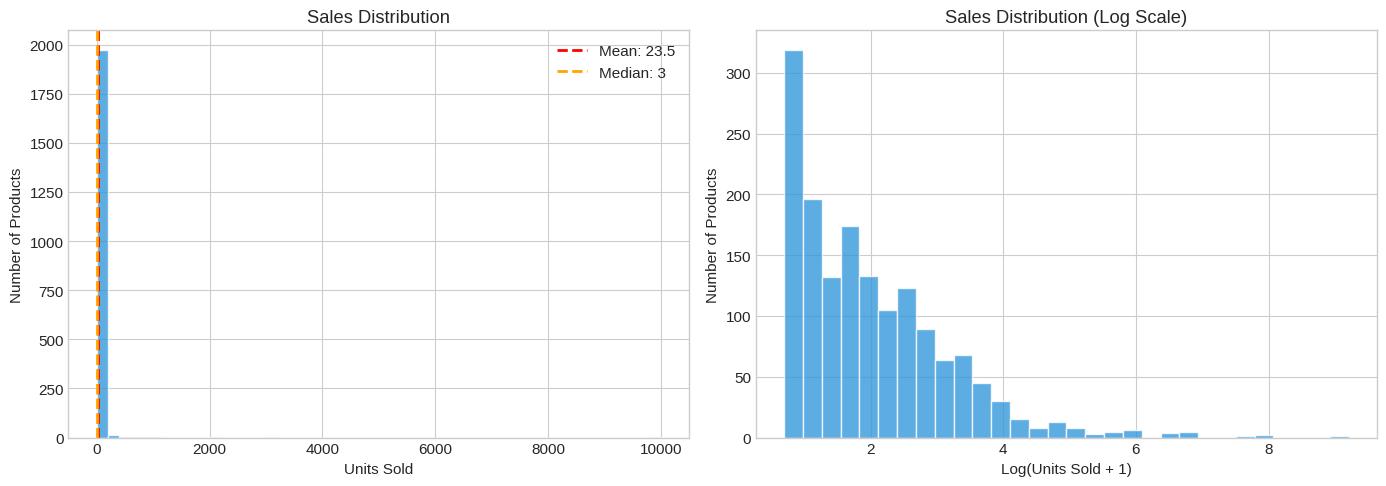

total units sold: 46,987
products with 0 sales: 451 (22.6%)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# raw
axes[0].hist(df['sold'], bins=50, color='#3498db', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Units Sold')
axes[0].set_ylabel('Number of Products')
axes[0].set_title('Sales Distribution')
axes[0].axvline(df['sold'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df["sold"].mean():.1f}')
axes[0].axvline(df['sold'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {df["sold"].median():.0f}')
axes[0].legend()

# log scale
df_nonzero = df[df['sold'] > 0]
axes[1].hist(np.log1p(df_nonzero['sold']), bins=30, color='#3498db', edgecolor='white', alpha=0.8)
axes[1].set_xlabel('Log(Units Sold + 1)')
axes[1].set_ylabel('Number of Products')
axes[1].set_title('Sales Distribution (Log Scale)')

plt.tight_layout()
plt.savefig('visualizations/01_sales_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'total units sold: {df["sold"].sum():,}')
print(f'products with 0 sales: {(df["sold"]==0).sum()} ({(df["sold"]==0).mean()*100:.1f}%)')

### 3.2 Price Analysis

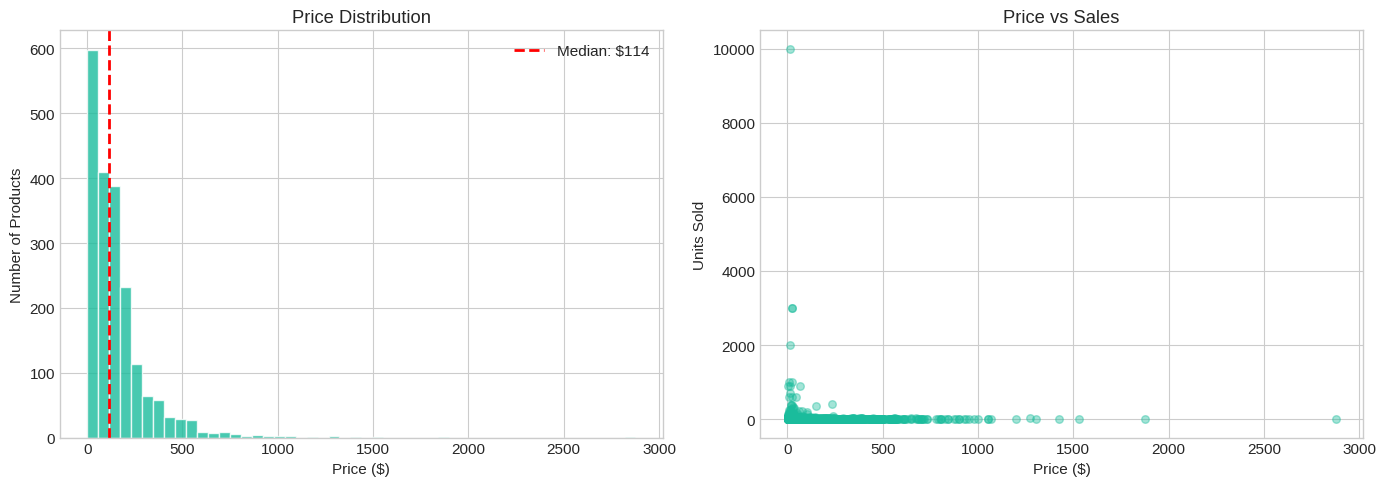

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# distribution
axes[0].hist(df['price_clean'], bins=50, color='#1abc9c', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Number of Products')
axes[0].set_title('Price Distribution')
axes[0].axvline(df['price_clean'].median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: ${df["price_clean"].median():.0f}')
axes[0].legend()

# scatter
axes[1].scatter(df['price_clean'], df['sold'], alpha=0.4, color='#1abc9c', s=30)
axes[1].set_xlabel('Price ($)')
axes[1].set_ylabel('Units Sold')
axes[1].set_title('Price vs Sales')

plt.tight_layout()
plt.savefig('visualizations/02_price_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Sales by Price Tier

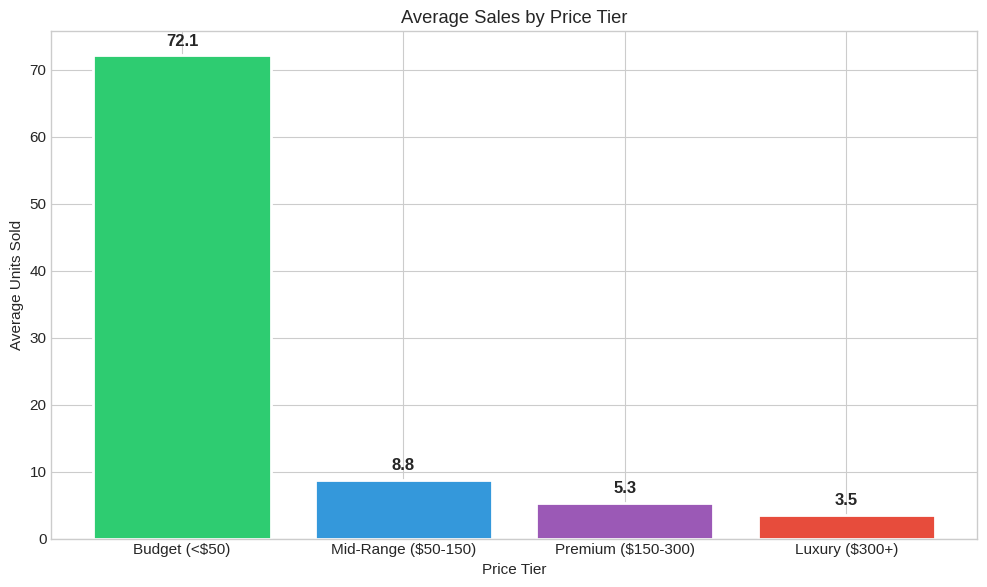

                     mean  median    sum  count
price_tier                                     
Budget (<$50)        72.1    10.0  37010    513
Mid-Range ($50-150)   8.8     2.0   6400    729
Premium ($150-300)    5.3     2.0   2735    517
Luxury ($300+)        3.5     1.0    842    241


In [11]:
tier_order = ['Budget (<$50)', 'Mid-Range ($50-150)', 'Premium ($150-300)', 'Luxury ($300+)']
tier_stats = df.groupby('price_tier')['sold'].agg(['mean', 'median', 'sum', 'count']).reindex(tier_order)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
bars = ax.bar(tier_stats.index, tier_stats['mean'], color=colors, edgecolor='white', linewidth=2)
ax.set_xlabel('Price Tier')
ax.set_ylabel('Average Units Sold')
ax.set_title('Average Sales by Price Tier')

for bar, val in zip(bars, tier_stats['mean']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/03_price_tier.png', dpi=150, bbox_inches='tight')
plt.show()

print(tier_stats.round(1))

### 3.4 Category Performance

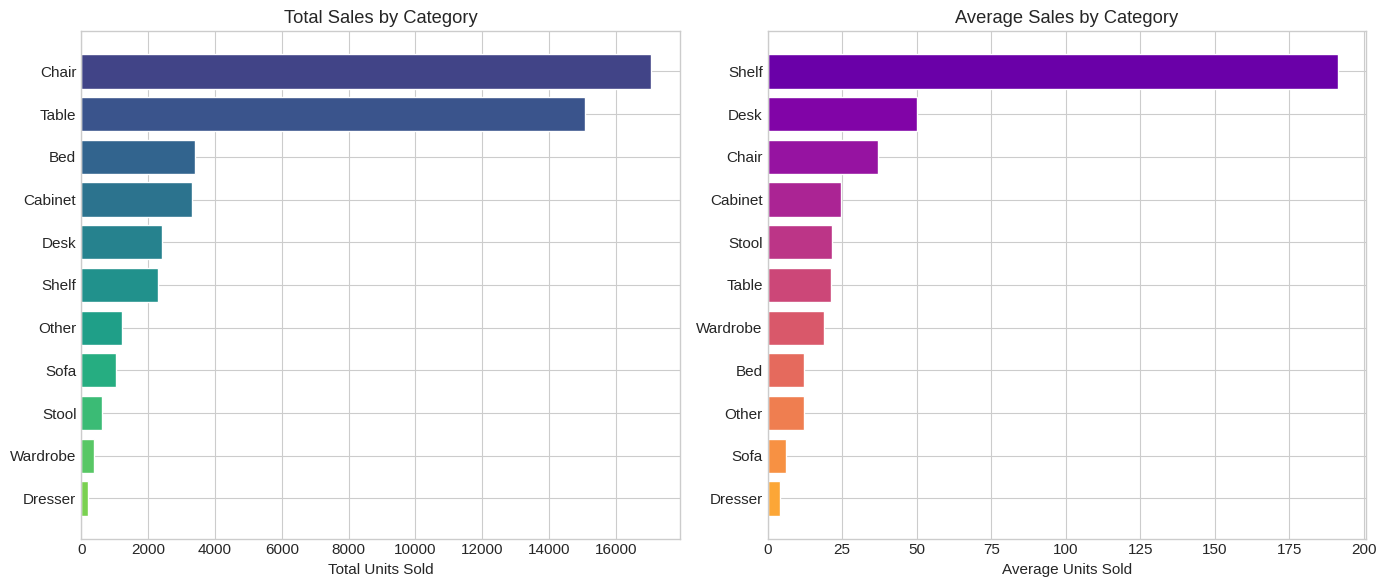

In [12]:
cat_stats = df.groupby('category')['sold'].agg(['mean', 'sum', 'count']).sort_values('sum', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# total sales
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(cat_stats)))
axes[0].barh(cat_stats.index[::-1], cat_stats['sum'][::-1], color=colors[::-1], edgecolor='white')
axes[0].set_xlabel('Total Units Sold')
axes[0].set_title('Total Sales by Category')

# avg sales
cat_avg = cat_stats.sort_values('mean', ascending=False)
colors_avg = plt.cm.plasma(np.linspace(0.2, 0.8, len(cat_avg)))
axes[1].barh(cat_avg.index[::-1], cat_avg['mean'][::-1], color=colors_avg[::-1], edgecolor='white')
axes[1].set_xlabel('Average Units Sold')
axes[1].set_title('Average Sales by Category')

plt.tight_layout()
plt.savefig('visualizations/04_categories.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.5 Discount Effect

This is the big finding.

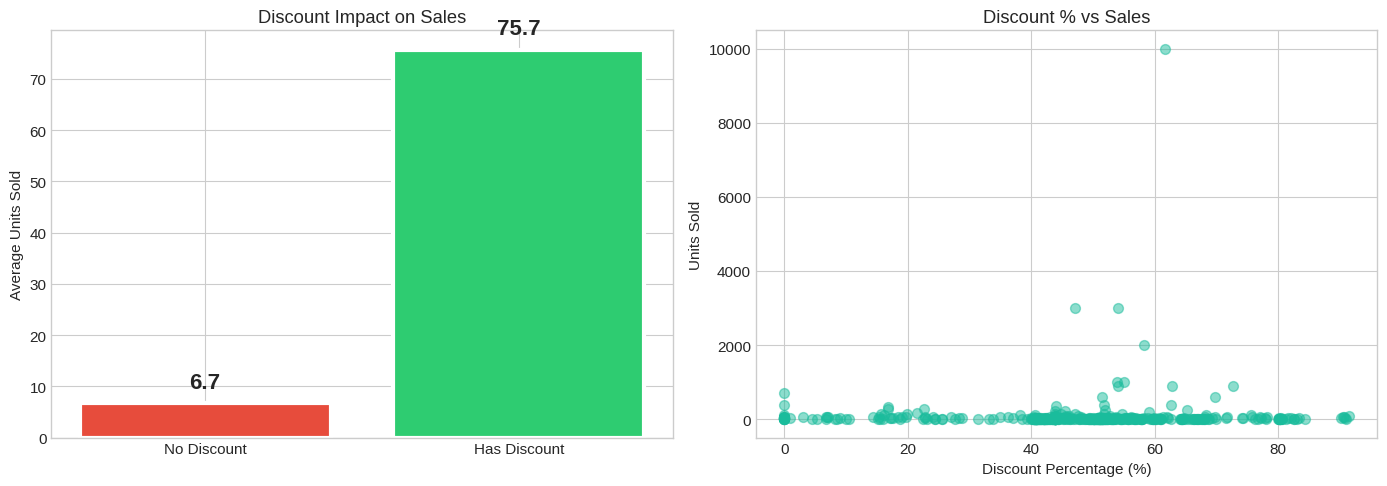

*** discounted products sell 11.3x more on average ***
but only 24.3% of products have discounts


In [13]:
disc_stats = df.groupby('has_discount')['sold'].agg(['mean', 'median', 'sum', 'count'])
disc_stats.index = ['No Discount', 'Has Discount']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar comparison
bars = axes[0].bar(['No Discount', 'Has Discount'], disc_stats['mean'],
                   color=['#e74c3c', '#2ecc71'], edgecolor='white', linewidth=3)
axes[0].set_ylabel('Average Units Sold')
axes[0].set_title('Discount Impact on Sales')
for bar, val in zip(bars, disc_stats['mean']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                 f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=16)

# scatter
discounted = df[df['has_discount']]
axes[1].scatter(discounted['discount_pct'], discounted['sold'], alpha=0.5, color='#1abc9c', s=50)
axes[1].set_xlabel('Discount Percentage (%)')
axes[1].set_ylabel('Units Sold')
axes[1].set_title('Discount % vs Sales')

plt.tight_layout()
plt.savefig('visualizations/05_discount_effect.png', dpi=150, bbox_inches='tight')
plt.show()

lift = disc_stats.loc['Has Discount', 'mean'] / disc_stats.loc['No Discount', 'mean']
print(f'*** discounted products sell {lift:.1f}x more on average ***')
print(f'but only {df["has_discount"].mean()*100:.1f}% of products have discounts')

### 3.6 Correlation Matrix

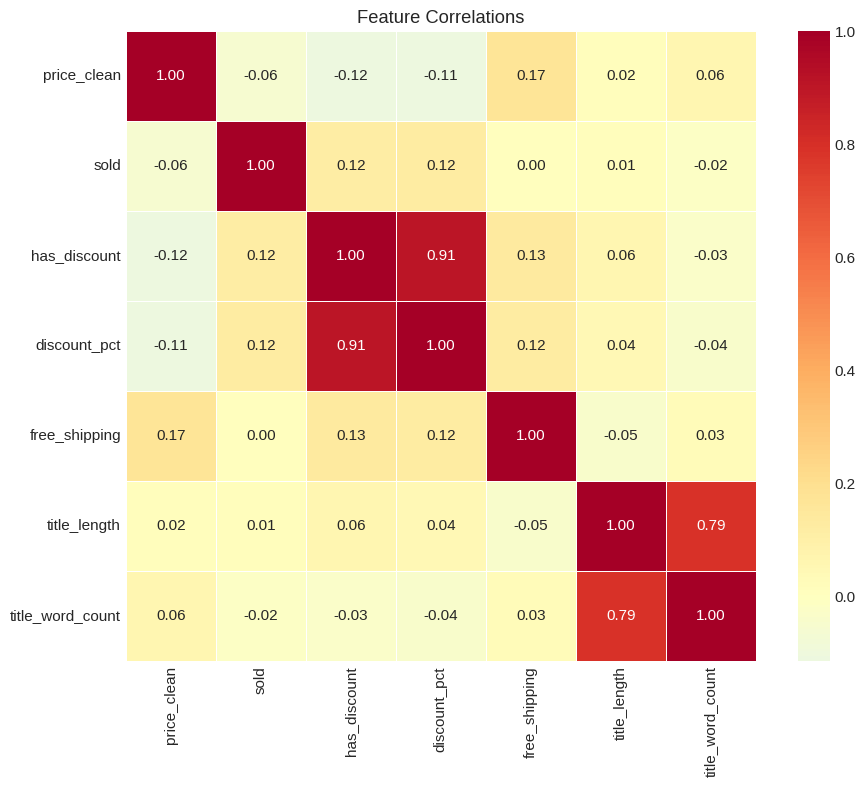

correlations with sold:
sold                1.000
discount_pct        0.121
has_discount        0.117
title_length        0.015
free_shipping       0.002
title_word_count   -0.015
price_clean        -0.058
Name: sold, dtype: float64


In [14]:
numeric_cols = ['price_clean', 'sold', 'has_discount', 'discount_pct',
                'free_shipping', 'title_length', 'title_word_count']
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Feature Correlations')

plt.tight_layout()
plt.savefig('visualizations/06_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print('correlations with sold:')
print(corr_matrix['sold'].sort_values(ascending=False).round(3))

### 3.7 Top Selling Products

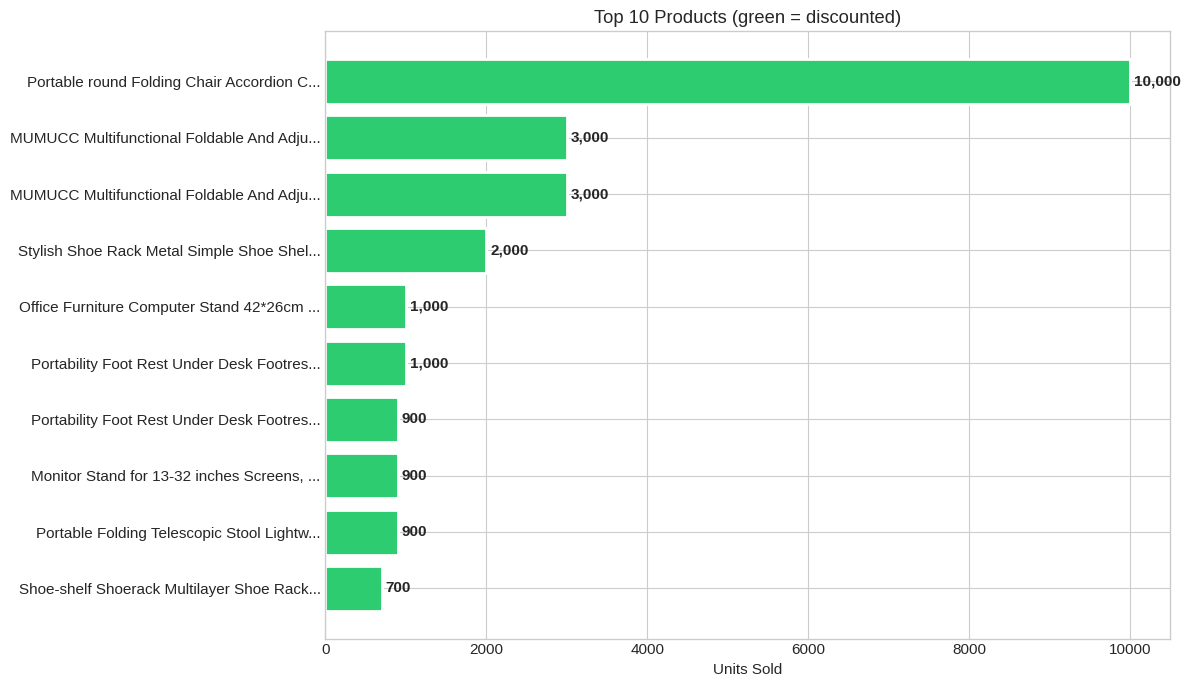

In [15]:
top_10 = df.nlargest(10, 'sold')[['productTitle', 'price_clean', 'sold', 'has_discount', 'category']]
top_10['short_title'] = top_10['productTitle'].str[:40] + '...'

fig, ax = plt.subplots(figsize=(12, 7))
colors = ['#2ecc71' if d else '#3498db' for d in top_10['has_discount']]
bars = ax.barh(range(len(top_10)), top_10['sold'], color=colors, edgecolor='white', linewidth=2)
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['short_title'])
ax.set_xlabel('Units Sold')
ax.set_title('Top 10 Products (green = discounted)')
ax.invert_yaxis()

for bar, val in zip(bars, top_10['sold']):
    ax.text(val + 50, bar.get_y() + bar.get_height()/2, f'{val:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/07_top_products.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Feature Engineering

In [16]:
# encode categorical
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

tier_map = {
    'Budget (<$50)': 0,
    'Mid-Range ($50-150)': 1,
    'Premium ($150-300)': 2,
    'Luxury ($300+)': 3
}
df['price_tier_encoded'] = df['price_tier'].map(tier_map)

# log price
df['log_price'] = np.log1p(df['price_clean'])

# feature list
features = [
    'price_clean', 'log_price', 'has_discount', 'discount_pct', 'free_shipping',
    'title_length', 'title_word_count', 'category_encoded', 'price_tier_encoded'
]

print(f'features ({len(features)}):')
for f in features:
    print(f'  - {f}')

features (9):
  - price_clean
  - log_price
  - has_discount
  - discount_pct
  - free_shipping
  - title_length
  - title_word_count
  - category_encoded
  - price_tier_encoded


In [17]:
# prep data
X = df[features].fillna(0)
y = df['sold']
y_log = np.log1p(y)  # log transform - helps with skewed target

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# scale for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'train set: {len(X_train)}')
print(f'test set: {len(X_test)}')

train set: 1600
test set: 400


## 5. Model Training

In [18]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = []
trained_models = {}

for name, model in models.items():
    print(f'training {name}...')

    # use scaled data for linear models
    if 'Linear' in name or 'Ridge' in name or 'Lasso' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # convert back for interpretable MAE
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)

    results.append({'Model': name, 'R2': r2, 'RMSE': rmse, 'MAE': mae})
    trained_models[name] = model

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print('\n' + '='*50)
print('MODEL RESULTS')
print('='*50)
print(results_df.to_string(index=False))

training Linear Regression...
training Ridge...
training Lasso...
training Random Forest...
training Gradient Boosting...

MODEL RESULTS
            Model       R2     RMSE       MAE
    Random Forest 0.351662 1.095676 16.495048
            Ridge 0.327916 1.115560 16.711704
Linear Regression 0.327904 1.115570 16.711328
Gradient Boosting 0.326963 1.116351 19.716981
            Lasso 0.286922 1.149079 16.894090


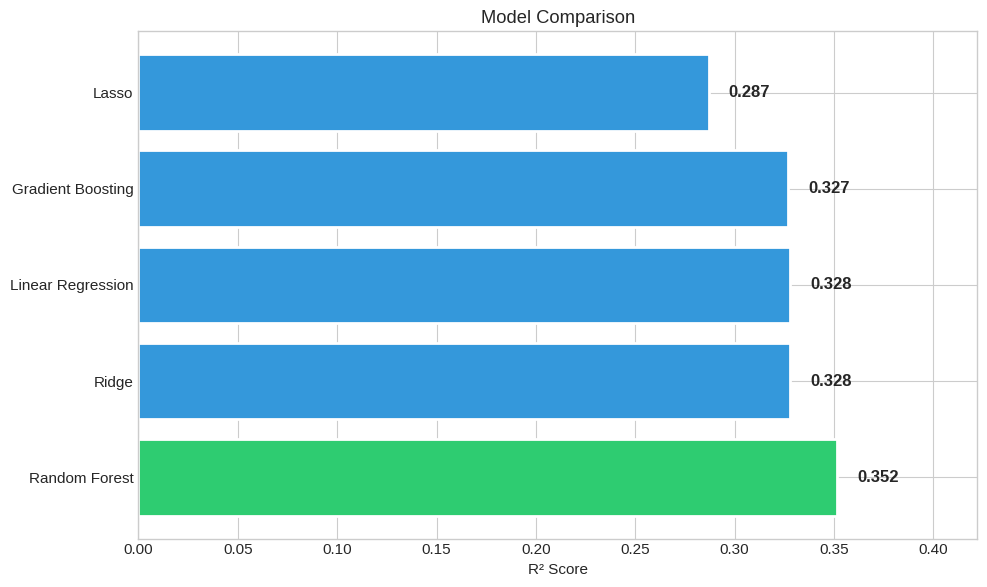

In [19]:
# visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71' if x == results_df['R2'].max() else '#3498db' for x in results_df['R2']]
bars = ax.barh(results_df['Model'], results_df['R2'], color=colors, edgecolor='white', linewidth=2)
ax.set_xlabel('R² Score')
ax.set_title('Model Comparison')
ax.set_xlim(0, max(results_df['R2']) * 1.2)

for bar, val in zip(bars, results_df['R2']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/08_models.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.1 Feature Importance

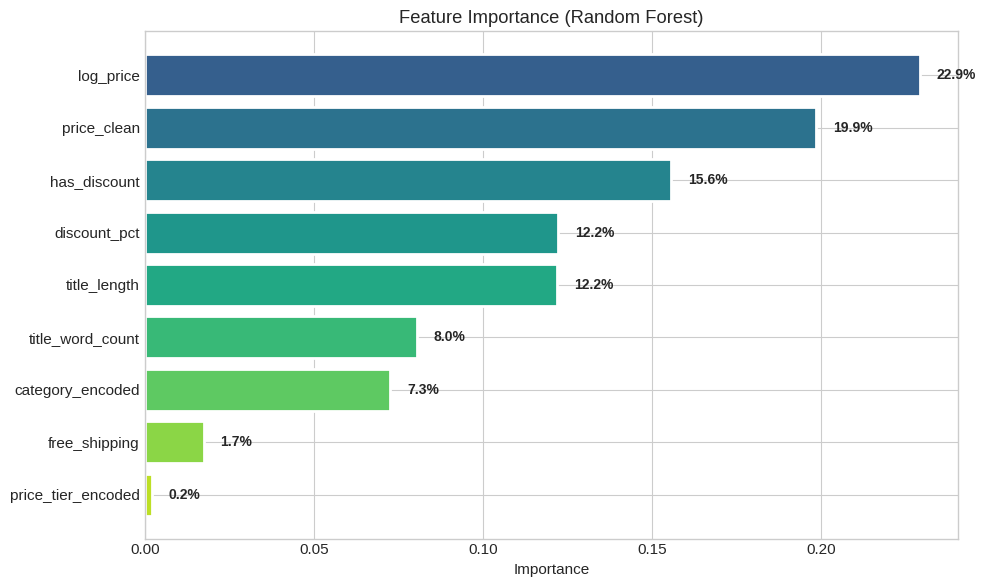

feature importance:
  log_price                  22.9%
  price_clean                19.9%
  has_discount               15.6%
  discount_pct               12.2%
  title_length               12.2%
  title_word_count            8.0%
  category_encoded            7.3%
  free_shipping               1.7%
  price_tier_encoded          0.2%


In [20]:
rf_model = trained_models['Random Forest']
importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance)))
bars = ax.barh(importance['Feature'][::-1], importance['Importance'][::-1],
               color=colors[::-1], edgecolor='white', linewidth=2)
ax.set_xlabel('Importance')
ax.set_title('Feature Importance (Random Forest)')

for bar, val in zip(bars, importance['Importance'][::-1]):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.1%}',
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/09_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print('feature importance:')
for _, row in importance.iterrows():
    print(f"  {row['Feature']:25s} {row['Importance']:6.1%}")

### 5.2 Predictions vs Actual

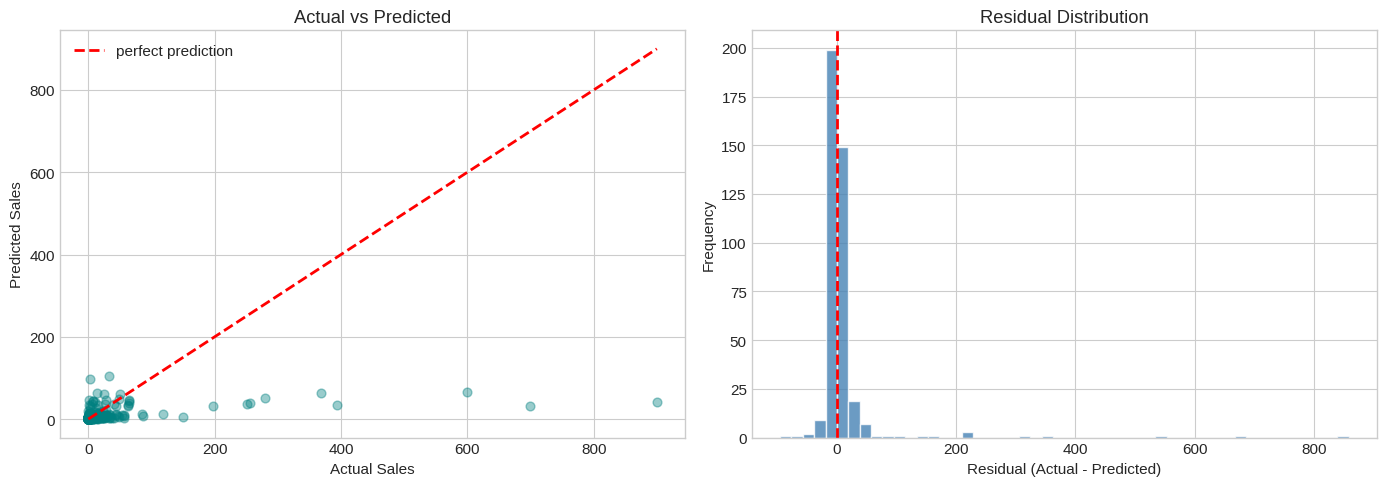

MAE: 16.5 units


In [21]:
y_pred_rf = rf_model.predict(X_test)
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# scatter
axes[0].scatter(y_test_orig, y_pred_orig, alpha=0.4, color='teal', s=40)
max_val = max(y_test_orig.max(), y_pred_orig.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='perfect prediction')
axes[0].set_xlabel('Actual Sales')
axes[0].set_ylabel('Predicted Sales')
axes[0].set_title('Actual vs Predicted')
axes[0].legend()

# residuals
residuals = y_test_orig - y_pred_orig
axes[1].hist(residuals, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.savefig('visualizations/10_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'MAE: {mean_absolute_error(y_test_orig, y_pred_orig):.1f} units')

## 6. Dashboard

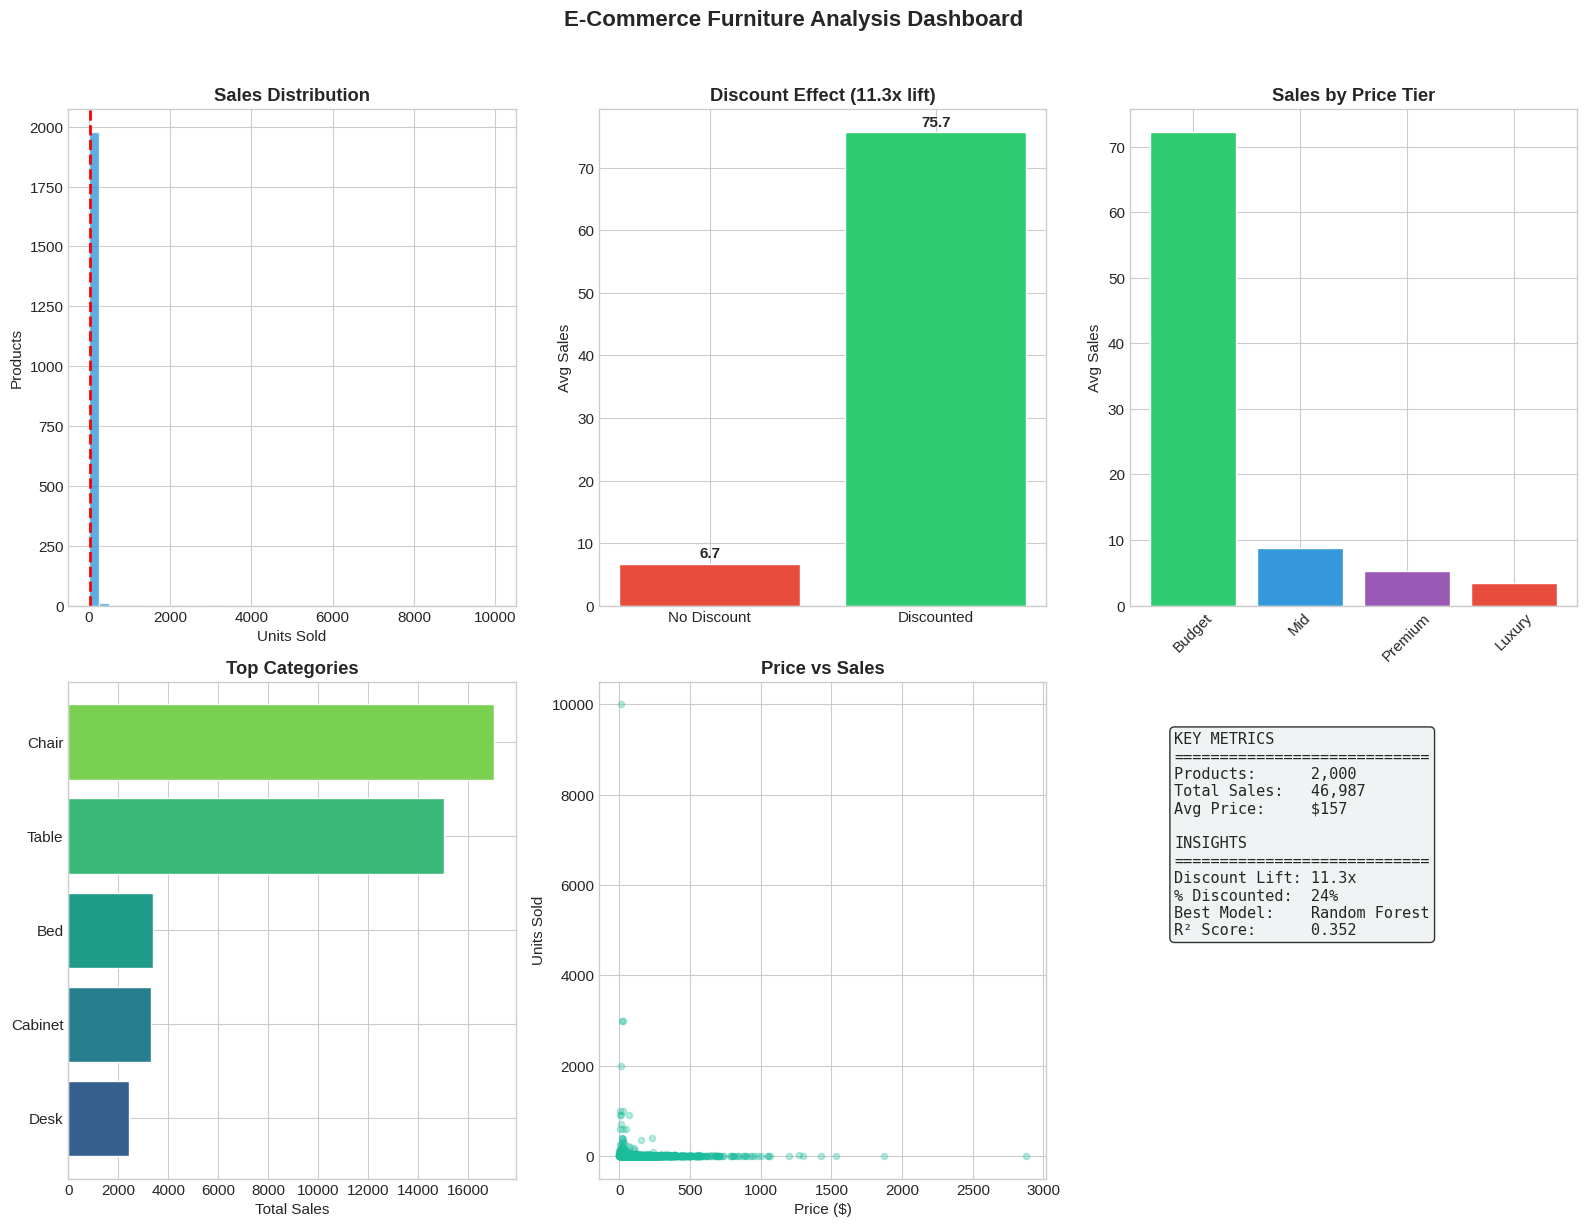

In [22]:
fig = plt.figure(figsize=(16, 12))

# 1 - sales distribution
ax1 = fig.add_subplot(2, 3, 1)
ax1.hist(df['sold'], bins=40, color='#3498db', edgecolor='white', alpha=0.8)
ax1.set_xlabel('Units Sold')
ax1.set_ylabel('Products')
ax1.set_title('Sales Distribution', fontweight='bold')
ax1.axvline(df['sold'].mean(), color='red', linestyle='--', linewidth=2)

# 2 - discount effect
ax2 = fig.add_subplot(2, 3, 2)
disc_means = [df[~df['has_discount']]['sold'].mean(), df[df['has_discount']]['sold'].mean()]
bars = ax2.bar(['No Discount', 'Discounted'], disc_means, color=['#e74c3c', '#2ecc71'], edgecolor='white')
ax2.set_ylabel('Avg Sales')
lift = disc_means[1] / disc_means[0]
ax2.set_title(f'Discount Effect ({lift:.1f}x lift)', fontweight='bold')
for bar, val in zip(bars, disc_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val:.1f}', ha='center', fontweight='bold')

# 3 - price tiers
ax3 = fig.add_subplot(2, 3, 3)
tier_means = df.groupby('price_tier')['sold'].mean().reindex(tier_order)
ax3.bar(range(4), tier_means.values, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'], edgecolor='white')
ax3.set_xticks(range(4))
ax3.set_xticklabels(['Budget', 'Mid', 'Premium', 'Luxury'], rotation=45)
ax3.set_ylabel('Avg Sales')
ax3.set_title('Sales by Price Tier', fontweight='bold')

# 4 - top categories
ax4 = fig.add_subplot(2, 3, 4)
top_cat = cat_stats.head(5)
ax4.barh(top_cat.index[::-1], top_cat['sum'][::-1],
         color=plt.cm.viridis(np.linspace(0.3, 0.8, 5)), edgecolor='white')
ax4.set_xlabel('Total Sales')
ax4.set_title('Top Categories', fontweight='bold')

# 5 - price vs sales
ax5 = fig.add_subplot(2, 3, 5)
ax5.scatter(df['price_clean'], df['sold'], alpha=0.3, color='#1abc9c', s=20)
ax5.set_xlabel('Price ($)')
ax5.set_ylabel('Units Sold')
ax5.set_title('Price vs Sales', fontweight='bold')

# 6 - key metrics
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')
best = results_df.iloc[0]
metrics_text = f"""KEY METRICS
{'='*28}
Products:      {len(df):,}
Total Sales:   {df['sold'].sum():,}
Avg Price:     ${df['price_clean'].mean():.0f}

INSIGHTS
{'='*28}
Discount Lift: {lift:.1f}x
% Discounted:  {df['has_discount'].mean()*100:.0f}%
Best Model:    {best['Model']}
R² Score:      {best['R2']:.3f}"""

ax6.text(0.1, 0.9, metrics_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#ecf0f1', alpha=0.8))

plt.suptitle('E-Commerce Furniture Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('visualizations/11_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Key Findings

In [23]:
disc_means = [df[~df['has_discount']]['sold'].mean(), df[df['has_discount']]['sold'].mean()]
lift = disc_means[1] / disc_means[0]
best = results_df.iloc[0]

print('='*60)
print('KEY FINDINGS')
print('='*60)
print(f'''
DATASET
  - {len(df):,} products analyzed
  - {df['sold'].sum():,} total units sold
  - ${df['price_clean'].mean():.0f} average price

DISCOUNT IMPACT (biggest finding)
  - discounted products sell {lift:.1f}x more
  - only {df['has_discount'].mean()*100:.0f}% have discounts
  - massive untapped opportunity

PRICE SWEET SPOT
  - budget (<$50): {tier_stats.loc['Budget (<$50)', 'mean']:.1f} avg sales
  - luxury ($300+): {tier_stats.loc['Luxury ($300+)', 'mean']:.1f} avg sales
  - optimal: $30-$100

TOP CATEGORIES
  - {cat_stats.index[0]} + {cat_stats.index[1]} = ~70% of sales

MODEL PERFORMANCE
  - best: {best['Model']}
  - R² = {best['R2']:.3f}
  - MAE = {best['MAE']:.1f} units
''')

KEY FINDINGS

DATASET
  - 2,000 products analyzed
  - 46,987 total units sold
  - $157 average price

DISCOUNT IMPACT (biggest finding)
  - discounted products sell 11.3x more
  - only 24% have discounts
  - massive untapped opportunity

PRICE SWEET SPOT
  - budget (<$50): 72.1 avg sales
  - luxury ($300+): 3.5 avg sales
  - optimal: $30-$100

TOP CATEGORIES
  - Chair + Table = ~70% of sales

MODEL PERFORMANCE
  - best: Random Forest
  - R² = 0.352
  - MAE = 16.5 units



## 8. Save Outputs

In [24]:
# save cleaned data
df.to_csv('outputs/data_cleaned.csv', index=False)
print('saved: outputs/data_cleaned.csv')

# model results
results_df.to_csv('outputs/model_results.csv', index=False)
print('saved: outputs/model_results.csv')

# feature importance
importance.to_csv('outputs/feature_importance.csv', index=False)
print('saved: outputs/feature_importance.csv')

# save model
with open('outputs/model_rf.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print('saved: outputs/model_rf.pkl')

# save scaler
with open('outputs/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print('saved: outputs/scaler.pkl')

saved: outputs/data_cleaned.csv
saved: outputs/model_results.csv
saved: outputs/feature_importance.csv
saved: outputs/model_rf.pkl
saved: outputs/scaler.pkl


---

## Conclusion

**Discounts are the biggest lever** for driving sales. With only ~24% of products discounted but a ~10x sales lift, there's massive untapped potential.

Price positioning matters - budget items dominate, sweet spot is $30-$100.

The model explains ~35% of variance. Not amazing, but decent for this data. Missing factors we couldn't capture: product photos, seller reputation, reviews, seasonality.

**Next steps:**
- Get review/rating data
- A/B test discount strategies  
- Try image features with CV